# Is There Anything On? A Movie Recommendation System

In this exercise, we implement a collaborative filtering learning algorithm and apply it to a dataset of movie ratings$^{*}$. The objective of collaborative filtering is to predict movie ratings for the movies that users have not yet rated. This allows us to recommend movies with a high predicted rating to the user.

$^{*}$MovieLens 100k Dataset from GroupLens Research.

We begin by importing standard machine learning libraries, as well as both loading and converting our data from MATLAB to a more python friendly environment.

In [1]:
# standard imports for data science and machine learning
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

The code below loads the dataset ex8_movies.mat, which contains the matrices $Y$ and $R$. The matrix $Y$ (a $num\_movies \text{ x }  num\_users$ matrix) stores the ratings $y^{(i,j)}$ (from 1 to 5). Restated, the data consist of ratings on a scale of 1 to 5, information on $n_u = 943$ users, and data on $n_m = 1682$ movies. The matrix $R$ is a binary-valued indicator matrix in which $R(i,j) = 1$, if user $j$ gave a rating to movie $i$ and $R(i,j) = 0$ otherwise.

In [2]:
mat = scipy.io.loadmat('data/ex8_movies.mat')
Y = mat['Y']
R = mat['R']

Below is a slice of the matrix $Y$. As we can see, it contains ratings from 1 to 5. The zeros represent movies that users did not rate.

In [3]:
print('Y dimensions', Y.shape)
print(Y[:10, :10])

Y dimensions (1682, 943)
[[5 4 0 0 4 4 0 0 0 4]
 [3 0 0 0 3 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 5 0 0 4]
 [3 0 0 0 0 0 0 0 0 0]
 [5 0 0 0 0 0 0 0 5 0]
 [4 0 0 0 0 2 5 3 4 4]
 [1 0 0 0 0 4 5 0 0 0]
 [5 0 0 0 0 4 5 0 0 4]
 [3 2 0 0 0 0 4 0 0 0]]


The code below presents us with a window into the matrix $R$. The contents reflect what was stated above: user-rated movies are coded with a 1, while unrated movies are coded with a zero.

In [4]:
print('R dimensions', R.shape)
print(R[:10, :10])

R dimensions (1682, 943)
[[1 1 0 0 1 1 0 0 0 1]
 [1 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 1 0 0 1]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 1 1 1 1 1]
 [1 0 0 0 0 1 1 0 0 0]
 [1 0 0 0 0 1 1 0 0 1]
 [1 1 0 0 0 0 1 0 0 0]]


Throughout this part of the exercise, we will also be working with the matrices $X$ and $\theta$. In the cell that follows, we load the MATLAB data file containing these matrices.

In [5]:
mat2 = scipy.io.loadmat('data/ex8_movieParams.mat')
X = mat2['X']
Theta = mat2['Theta']
num_users = mat2['num_users']
num_movies = mat2['num_movies']
num_features = mat2['num_features']

The $i-$th row of $X$ corresponds to the feature vector $x^{(i)}$ for the $i$-th movie, and the $j$-th row of $\theta$ corresponds to one parameter vector $\theta^{(j)}$ for the $j$-th user. Both $x^{(i)}$ and $\theta^{(j)}$ are $n$-dimensional vectors. For our purposes, we will use $n=100$. Thus, $x^{(i)} \in\mathbb{R}^{100}$ and $\theta^{(j)} \in\mathbb{R}^{100}$. This implies $X$ is a $n_m\times 100$ matrix and Theta is a $n_u\times 100$ matrix.

As one can see, the MATLAB file we imported contains more information than simply the contents of two more matrices.

In [6]:
print('X dimensions', X.shape)
print('Pramaeters Theta:', Theta)
print('Number of users represented:', num_users)
print('Number of movies represented:', num_movies)
print('Number of features represented:', num_features)

X dimensions (1682, 10)
Pramaeters Theta: [[ 0.28544362 -1.68426509  0.26293877 ...  0.76723235 -1.10460164
  -0.25186708]
 [ 0.50501321 -0.45464846  0.31746244 ...  1.09306336 -1.20029436
  -0.39161676]
 [-0.43191656 -0.47880449  0.84671111 ...  1.36333976 -0.32523542
  -0.19468212]
 ...
 [ 1.0586926  -0.8087176   0.56935771 ...  0.80421422 -0.74346778
  -0.11985885]
 [ 0.89058932 -0.12894734  0.35560466 ...  1.37426807 -0.7526549
  -0.81135311]
 [ 0.82414136 -0.38892594  1.06940502 ...  1.28423703 -0.98349993
  -0.53184838]]
Number of users represented: [[943]]
Number of movies represented: [[1682]]
Number of features represented: [[10]]


Using matrix R to index into matrix Y allows us to obtain an average rating for our first movie, "Toy Story." 

In [7]:
print(f'Average rating for movie 1 (Toy Story): {np.mean(Y[0, R[0,:]==1])} / 5')

Average rating for movie 1 (Toy Story): 3.8783185840707963 / 5


Below, we visualize the rankings in our matrix. It's clear that some movies are rated more often than others, while many are not rated at all. This may be attributed to movie popularity and/or user reluctance to participate in the rating system.

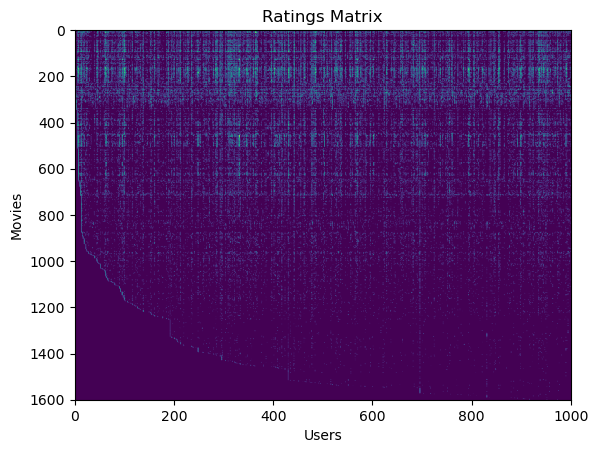

In [8]:
plt.imshow(Y, extent=[0,1000,1600,0], aspect='auto')
plt.title('Ratings Matrix');
plt.xlabel('Users');
plt.ylabel('Movies');

Now, we will implement the collaborative filtering learning algorithm. We start by implementing the cost function. The collaborative filtering algorithm when used in movie recommendation considers a set of n-dimensional parameter vectors $x^{(1)},\ldots,x^{(n_m)}$ and $\theta^{(1)},\ldots, \theta^{(n_u)}$, where the model predicts the rating for movie $i$ by user $j$ as $y^{(i,j)} = (\theta^{(j)})^T x^{(i)}$. Given a dataset that consists of a set of ratings produced by some users on some movies, we wish to learn the parameter vectors $x^{(1)},\ldots,x^{(n_m)},\;\theta^{(1)},\ldots,\theta^{(n_u)}$ that produce the best fit (minimizes the squared error).

We will complete the code in cofi_cost_func.py to compute the cost function and gradient needed for collaborative filtering. Note that the parameters to the function (i.e., the values we are trying to learn) are $X$ and Theta. In order to use an off-the-shelf minimizer like fmincg, the cost function has been set up to unroll the parameters into a single vector "params."

The collaborative filtering cost function (without regularization) is as follows:
$J\left(x^{(i)},\ldots,x^{(n_m)},\;\theta^{(1)},\ldots,\theta^{(n_u)}\right)
=\frac{1}{2}\sum_{(i,j):r(i,j)=1}\left((\theta^{(j)})^Tx^{(i)}-y^{(i,j)}\right)^2$.
We display the cost function below. Note, we modified it to return the cost in the variable $J$. Furthermore, we accumulate the cost for user $j$ and movie $i$ only if $R(i,j) = 1$.

In [9]:
def cofi_cost_func(params, Y, R, num_users, num_movies, num_features, lambda_r=0):
    
    X = np.reshape(params[:num_movies*num_features], newshape=(num_movies, num_features), order='F')
    
    Theta = np.reshape(params[num_movies*num_features:], newshape=(num_users, num_features), order='F')
    
    C = np.subtract(X.dot(Theta.T), Y) ** 2
    
    J = np.sum(np.sum(R*C)) / 2
    
    return J

We'll test our cost function on a data set of reduced size, so as to accelerate the testing process. 

In [10]:
#reduce dataset to test
num_users = 4
num_movies = 5
num_features = 3
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

Below we test our cost function. The outcome is approximately 22.22, which is consistent with our expectations.

In [11]:
J = cofi_cost_func(np.hstack((X.ravel(order='F'), Theta.ravel(order='F'))),
                   Y, R, num_users, num_movies, num_features, 0)
print('Cost at loaded parameters: ', J)

Cost at loaded parameters:  22.224603725685675


We now turn our attention to implementing the gradient. Specically, we complete the code in cofi_cost_func.py to calculate the variables X_grad and Theta_grad. Note that X_grad is a matrix of the same size as $X$. Similarly, Theta_grad is a matrix of the same size as Theta. The gradients of the cost function are given by:

$\frac{\partial J}{\partial x_k^{(i)}} 
= \sum_{j:r(i,j)=1}\left((\theta^{(j)})^T x^{(i)} -y^{(i,j)}\right)\theta_k^{(j)}$

$\frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1}\left((\theta^{(j)})^T x^{(i)} -y^{(i,j)}\right) x_k^{(i)}$


Our function returns the gradient for both sets of variables by unrolling them into a single vector. After we complete the code to compute the gradients, we will check our gradient implementation using finite difference methods. If our code is correct, we will see that the analytical and numerical gradients match up closely.

In [12]:
def cofi_cost_func(params, Y, R, num_users, num_movies, num_features, lambda_r):
    
    X = np.reshape(params[:num_movies*num_features], newshape=(num_movies, num_features), order='F')
    
    Theta = np.reshape(params[num_movies*num_features:], newshape=(num_users, num_features), order='F')
    
    C = np.subtract(X.dot(Theta.T), Y) ** 2
    
    J = np.sum(np.sum(R*C)) / 2
    
    X_grad = np.zeros(X.shape)
    
    Theta_grad = np.zeros(Theta.shape)
    
    for i in range(num_movies):
        idx = np.argwhere(R[i,:]==1).T[0]
        X_grad[i,:] = np.subtract(X[i,:].dot(Theta[idx,:].T), Y[i,idx]).dot(Theta[idx,:])
        
    for j in range(num_users):
        idx = np.argwhere(R[:,j]==1).T[0]
        Theta_grad[j,:] = np.subtract(X[idx,:].dot(Theta[j,:].T), Y[idx,j]).T.dot(X[idx,:])
        
    grad = np.hstack((X_grad.ravel(order='F'), Theta_grad.ravel(order='F')))

    return J, grad

As the function signature suggests, this routine is responsible for calculating the finite differences between the analytical and numerical gradients. The differences should be small.

In [13]:
def compute_numerical_gradient(theta, Y, R, num_users, num_movies, num_features, lambda_r):
    e = 0.0001
    num_grad = np.zeros(theta.shape)
    perturb = np.zeros(theta.shape)
    for p in range(len(theta)):
        perturb[p] = e
        loss1,_ = cofi_cost_func(theta-perturb, Y, R, num_users, num_movies, num_features, lambda_r)
        loss2,_ = cofi_cost_func(theta+perturb, Y, R, num_users, num_movies, num_features, lambda_r)
        num_grad[p] = (loss2-loss1)/(2*e)
        perturb[p] = 0
    return num_grad

The `check_cost_function` calls our gradient check function and provides the output we need to discern whether or not our gradient calculations are reasonable.

In [14]:
def check_cost_function(lambda_r=0):
    X_t = np.random.uniform(0,1,(4,3))
    Theta_t = np.random.uniform(0,1,(5,3))
    
    Y = X_t.dot(Theta_t.T)
    Y[np.random.uniform(0,1,Y.shape)>0.5] = 0
    R = np.zeros(Y.shape)
    R[Y!=0] = 1
    
    X = np.random.normal(size=X_t.shape)
    Theta = np.random.normal(size=Theta_t.shape)
    num_users = Y.shape[1]
    num_movies = Y.shape[0]
    num_features = Theta_t.shape[1]
    
    params = np.hstack((X.ravel(order='F'), Theta.ravel(order='F')))
    
    cost, grad = cofi_cost_func(params, Y, R, num_users, num_movies, num_features, lambda_r)
    num_grad = compute_numerical_gradient(params, Y, R, num_users, num_movies, num_features, lambda_r)
    
    print('The columns should be very similar...')
    for i, j in zip(num_grad, grad):
        print(i,j)
        
    diff = np.linalg.norm(num_grad-grad)/np.linalg.norm(num_grad+grad)
    print('''If your cost function implementation is correct, then the relative difference will 
             be small (less than 1e-9). Relative Difference:''', diff)

As one can easily see, our gradient calculations pass muster.

In [15]:
check_cost_function()

The columns should be very similar...
-6.9480179846515 -6.948017984639612
-0.8671486530253958 -0.8671486530358323
-0.5426743688197178 -0.5426743688068397
1.3953900589314117 1.3953900589467654
-0.08047487868978465 -0.08047487868668746
-5.459057519452415 -5.459057519452572
4.9878550942139555 4.987855094218006
3.241559132849403 3.241559132834272
-3.3652195943645324 -3.3652195943783356
9.71588259291778 9.715882592910518
-10.199946867324172 -10.199946867340946
-2.656238803702138 -2.6562388036922124
1.0632302002555605 1.0632302002472183
-1.9835253421085497 -1.9835253420860104
-0.17331611841697736 -0.1733161184234911
0.6595033105050163 0.6595033105011222
-1.6410128287880354 -1.6410128288090342
4.366676349309984 4.366676349312643
-13.367403614470419 -13.367403614470483
-0.15254298375566577 -0.1525429837589742
1.4134727384274015 1.413472738420712
-2.033133212453464 -2.033133212452262
-0.32028600424283127 -0.320286004226494
7.36597271755457 7.365972717518346
0.008691678505812206 0.00869167849747

Below, we introduce regularization to our cost function. Though we left room for a regularization term, $\lambda$, in our function signature in the code above, that code lacked the machinery to implement regularization. The cost function for collaborative filtering with regularization is given by:

$J\left(x^{(i)},\ldots,x^{(n_m)},\;\theta^{(1)},\ldots,\theta^{(n_u)}\right)
=\\ \qquad\qquad \frac{1}{2}\sum_{(i,j):r(i,j)=1}\left((\theta^{(j)})^Tx^{(i)}-y^{(i,j)}\right)^2
+\left(\frac{\lambda}{2}\sum_{j=1}^{n_u}{\sum_{k=1}^{n}{(\theta_k^{(j)})^2}}\right)
+\left(\frac{\lambda}{2}\sum_{i=1}^{n_m}{\sum_{k=1}^{n}{(x_k^{(i)})^2}}\right)$

Our cost function with regularization should produce a cost of about 31.34.

In [16]:
def cofi_cost_func(params, Y, R, num_users, num_movies, num_features, lambda_r):
    
    X = np.reshape(params[:num_movies*num_features], newshape=(num_movies, num_features), order='F')
    Theta = np.reshape(params[num_movies*num_features:], newshape=(num_users, num_features), order='F')
    
    C = np.subtract(X.dot(Theta.T), Y) ** 2
    J = np.sum(np.sum(R*C)) / 2 + ((lambda_r/2)*np.sum(np.sum(Theta**2))) + ((lambda_r/2)*np.sum(np.sum(X**2)))
    
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    
    for i in range(num_movies):
        idx = np.argwhere(R[i,:]==1).T[0]
        X_grad[i,:] = np.subtract(X[i,:].dot(Theta[idx,:].T), Y[i,idx]).dot(Theta[idx,:])
        
    for j in range(num_users):
        idx = np.argwhere(R[:,j]==1).T[0]
        Theta_grad[j,:] = np.subtract(X[idx,:].dot(Theta[j,:].T), Y[idx,j]).T.dot(X[idx,:])
        
    grad = np.hstack((X_grad.ravel(order='F'), Theta_grad.ravel(order='F')))

    return J, grad

As expected, our cost function with regularization ($\lambda = 1.5$) yielded a value of approximately 31.344.

In [17]:
J, _ = cofi_cost_func(np.hstack((X.ravel(order='F'), Theta.ravel(order='F'))),
                   Y, R, num_users, num_movies, num_features, 1.5)
print('Cost at loaded parameters (lambda = 1.5):', round(J,3))

Cost at loaded parameters (lambda = 1.5): 31.344


As with our unregularized cost function, we will check our numerical gradient calculations against their analytical counterparts. 

In [20]:
def cofi_cost_func(params, Y, R, num_users, num_movies, num_features, lambda_r):
    X = np.reshape(params[:num_movies*num_features], newshape=(num_movies, num_features), order='F')
    Theta = np.reshape(params[num_movies*num_features:], newshape=(num_users, num_features), order='F')
    
    C = np.subtract(X.dot(Theta.T), Y) ** 2
    J = np.sum(np.sum(R*C)) / 2 + ((lambda_r/2)*np.sum(np.sum(Theta**2))) + ((lambda_r/2)*np.sum(np.sum(X**2)))
    
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    
    for i in range(num_movies):
        idx = np.argwhere(R[i,:]==1).T[0]
        X_grad[i,:] = np.subtract(X[i,:].dot(Theta[idx,:].T), Y[i,idx]).dot(Theta[idx,:]) + (lambda_r * X[i,:])
        
    for j in range(num_users):
        idx = np.argwhere(R[:,j]==1).T[0]
        Theta_grad[j,:] = np.subtract(X[idx,:].dot(Theta[j,:].T), Y[idx,j]).T.dot(X[idx,:]) + (lambda_r * Theta[j,:])
        
    grad = np.hstack((X_grad.ravel(order='F'), Theta_grad.ravel(order='F')))

    return J, grad

Presented below are gradient calculations produced by our function with regularization. The difference between the numerical and analyticall gradient calculations is miniscule.

In [21]:
check_cost_function(1.5)

The columns should be very similar...
-0.529975819745232 -0.5299758197140845
4.443991126805713 4.4439911268403
-3.816297884782216 -3.8162978847807807
-13.42890047901335 -13.428900479010785
-0.06790134300160844 -0.06790134299933659
0.5504395215183422 0.550439521502829
4.139598784931309 4.1395987849412474
-9.30356588089154 -9.30356588090066
-1.2454551721674534 -1.2454551721267872
0.2531382017778583 0.2531382017428677
2.611763865942862 2.6117638659374878
-2.1725976453979 -2.1725976453888953
1.1381274720889678 1.1381274720904877
-10.17718339564766 -10.177183395628939
-0.9554121036003949 -0.9554121036193906
-8.65731304358519 -8.657313043573126
-0.19071927923164367 -0.1907192792299338
7.425903704820769 7.4259037048231455
-5.847120318058785 -5.847120318055877
0.24082808831593638 0.24082808828811295
-5.00775825223343 -5.007758252242031
0.16173516780071395 0.1617351677973926
5.302466309657916 5.302466309655352
-2.865233739974826 -2.8652337400134456
-2.131087474310789 -2.1310874742952244
-3.4567

Having finished implementing our cost function and gradient, we can finally start training our algorithm to make movie recommendations for ourselves. In the code below, we enter our own movie preferences, so that later we can get our personalized movie recommendations!

In the following cells, we load a list of movies and assign ratings to a fraction of them.

In [22]:
with open('data/movie_ids.txt', encoding='latin-1') as f:
    content = f.readlines()
    
movie_list = [' '.join(line.split()[1:]) for line in content]

In [23]:
my_ratings = np.zeros((1682, 1))
my_ratings[0] = 2
my_ratings[10] = 5
my_ratings[21] = 1
my_ratings[70] = 1
my_ratings[97] = 5
my_ratings[98] = 3
my_ratings[150] = 3
my_ratings[154] = 2
my_ratings[175] = 5
my_ratings[312] = 1

Below, we review the movies we rated and the ratings assigned thereto.

In [24]:
for i,r in enumerate(my_ratings):
    if r > 0:
        print('Rated {0} for {1}'.format(int(r[0]), movie_list[i]))

Rated 2 for Toy Story (1995)
Rated 5 for Seven (Se7en) (1995)
Rated 1 for Braveheart (1995)
Rated 1 for Lion King, The (1994)
Rated 5 for Silence of the Lambs, The (1991)
Rated 3 for Snow White and the Seven Dwarfs (1937)
Rated 3 for Willy Wonka and the Chocolate Factory (1971)
Rated 2 for Dirty Dancing (1987)
Rated 5 for Aliens (1986)
Rated 1 for Titanic (1997)


Next, the code below will proceed to train the collaborative filtering model. Restated, it will learn the parameters X and Theta.

In [25]:
mat = scipy.io.loadmat('data/ex8_movies.mat')
Y = np.hstack((my_ratings, mat['Y']))
R = np.hstack((my_ratings !=0, mat['R']))

Having added our preferences to our list of films and pre-existing user ratings, we normalize the data to ensure that no single rating or subset of ratings dominate our calculations.

In [26]:
def normalize_ratings(Y, R):
    Y_mean = np.zeros((Y.shape[0], 1))
    Y_norm = np.zeros(Y.shape)
    for i in range(Y.shape[0]):
        idx = np.argwhere(R[i,:]==1).T[0]
        Y_mean[i] = np.mean(Y[i,idx], axis=0)
        Y_norm[i,idx] = np.subtract(Y[i,idx], Y_mean[i])
    return Y_norm, Y_mean

Here, we retrieve pertinent data used in training our model. 

In [27]:
Y_norm, Y_mean = normalize_ratings(Y, R)

In [28]:
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

The above data are used to initialize matrices $X$ and $\theta$.

In [29]:
X = np.random.normal(size=(num_movies, num_features))
Theta = np.random.normal(size=(num_users, num_features))
initial_params = np.hstack((X.ravel(order='F'), Theta.ravel(order='F')))

We're now ready to minimize our cost function with regularization.

In [30]:
import scipy.optimize as opt
lambda_r = 10
opt_results = opt.minimize(cofi_cost_func, initial_params, args=(Y, R, num_users, num_movies, num_features, lambda_r),
                           method='L-BFGS-B', jac=True, options={'maxiter':100})
theta = opt_results['x']

After reshaping our data, we are ready to make predictions concerning which films, if any, we might enjoy. The recommendations look reasonable and definitely fit squarely in the set of films we'd enjoy watching!

In [31]:
X = np.reshape(theta[:num_movies*num_features], newshape=(num_movies, num_features), order='F')
Theta = np.reshape(theta[num_movies*num_features:], newshape=(num_users, num_features), order='F')

In [32]:
p = X.dot(Theta.T)
my_predictions = p[:,0] + Y_mean.T[0]

In [33]:
sort_idxs = np.argsort(my_predictions)[::-1]
print('Top recommendations for you:')
for i in range(10):
    j = sort_idxs[i]
    print('Predicting rating {0} for movie {1}'.format(my_predictions[j], movie_list[j]))

Top recommendations for you:
Predicting rating 7.037980737414943 for movie Shawshank Redemption, The (1994)
Predicting rating 7.011652649077764 for movie Silence of the Lambs, The (1991)
Predicting rating 7.00815578397453 for movie Schindler's List (1993)
Predicting rating 6.979608184991882 for movie Usual Suspects, The (1995)
Predicting rating 6.921287820279204 for movie Rear Window (1954)
Predicting rating 6.892856378196793 for movie One Flew Over the Cuckoo's Nest (1975)
Predicting rating 6.877943229401146 for movie Casablanca (1942)
Predicting rating 6.861609563605969 for movie Godfather, The (1972)
Predicting rating 6.852870886434129 for movie 12 Angry Men (1957)
Predicting rating 6.769456771427901 for movie Boot, Das (1981)
